In [70]:
# Thư viện
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from scipy import stats
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')

In [16]:
#read file 
df = pd.read_csv('CSGO_Market.csv')

In [17]:
Item_extra_list = ['StatTrak™', 'Souvenir', 'Normal']

Item_type_list = ['Rifle', 'Sniper Rifle', 'Pistol', 'SMG', 'Shotgun', 'Machinegun', 
                  'Knife', 'Gloves', 'Sticker', 'Container', 'Others']

Exterior_list = ['Battle-Scarred', 'Well-Worn', 'Field-Tested', 'Minimal Wear', 'Factory New', 'None']

Rarity_list = ['Base Grade', 'Consumer Grade', 'Industrial Grade', 'Mil-Spec', 'Restricted', 
               'Classified', 'Covert', 'Extraordinary',
                  'High Grade', 'Remarkable', 'Exotic', 'None']

In [18]:
df['Days to reach min'].mean()

562.8599895670318

In [19]:
print(len(df[df['Days to reach min'] < df['Days to reach max']]) / len(df))
print(len(df[df['Days to reach min'] > df['Days to reach max']]) / len(df))

0.5250912884715702
0.4748565466875326


In [20]:
print('Avg price by extra: ', '\n') 
for item in Item_extra_list:   
    print(item, ":", df[df['Extra'] == item]['Average price (VND)'].mean())
print(' ')
print('Avg price by type: ', '\n') 
for item in Item_type_list:   
    print(item, ":", df[df['Type'] == item]['Average price (VND)'].mean())
print(' ')

Avg price by extra:  

StatTrak™ : 1825015.5164573377
Souvenir : 638537.1542428073
Normal : 838875.8390217768
 
Avg price by type:  

Rifle : 884750.7902816571
Sniper Rifle : nan
Pistol : 291945.8927582509
SMG : 175595.33843803697
Shotgun : 113358.55286458871
Machinegun : 185540.11197481368
Knife : 5020627.454104856
Gloves : 8700526.042972788
Sticker : 137440.26580947376
Container : 250791.2563814286
Others : 31547.88150040375
 


In [21]:
print('Avg price by exterior: ', '\n') 
for item in Exterior_list:   
    print(item, ":", df[df['Exterior'] == item]['Average price (VND)'].mean())
print(' ')
print('Avg price by rarity: ', '\n') 
for item in Rarity_list:   
    print(item, ":", df[df['Rarity'] == item]['Average price (VND)'].mean())
print(' ')

Avg price by exterior:  

Battle-Scarred : 1157932.491807857
Well-Worn : 1108583.9248148182
Field-Tested : 1445926.5420879894
Minimal Wear : 1995114.501870035
Factory New : 2302772.4084820277
None : 142720.7978138154
 
Avg price by rarity:  

Base Grade : 55111.82257299852
Consumer Grade : 23959.061648847077
Industrial Grade : 86443.93714087906
Mil-Spec : 74667.4005763578
Restricted : 229928.84888554964
Classified : 916144.8561787975
Covert : 4537392.339362665
Extraordinary : 2645887.5469620214
High Grade : 39044.76628807081
Remarkable : 82370.4335950842
Exotic : 138678.88229737477
None : 163409.05964000005
 


## General idea: use multiple linear regression with input of rarity/extra/exterior to predict price of future skins.

- NO LINEAR REGRESSION for skins of 'others' type since we do not care about them.

- NO LINEAR REGRESSION for skins of 'container' type since they all have same rarity/extra/exterior and their value is determined by its possible content, which makes it beyond my (or linear regression's) ability to predict prices of future items of this type.

- Separate linear regression model for each of glove, knife and sticker skins as their rarity/extra/exterior works differently, other types get a shared model. 

## Gloves skin:

In [22]:
gloves = df[df['Type'] == 'Gloves']
gloves.head()

,Name,Type,Exterior,Rarity,Extra,Average volume sale,Average price (VND),Max price (VND),Days to reach max,Min price (VND),Days to reach min,Price change (%),Time on market (days)
4,★ Specialist Gloves | Emerald Web (Minimal Wear),Gloves,Minimal Wear,Extraordinary,Normal,1.130435,21938172.68,46029248.0,2192,7.007052e+06,453,3.71,2192
24,★ Moto Gloves | Spearmint (Well-Worn),Gloves,Well-Worn,Extraordinary,Normal,1.145455,12166266.35,37357056.0,2111,1.012486e+04,698,4.91,2182
25,★ Sport Gloves | Vice (Field-Tested),Gloves,Field-Tested,Extraordinary,Normal,1.576710,31272973.63,47962064.0,1629,4.114059e+06,1556,0.29,1744
27,★ Driver Gloves | Imperial Plaid (Factory New),Gloves,Factory New,Extraordinary,Normal,1.000000,38383019.00,47991816.0,1434,6.293330e+06,0,6.09,1539
30,★ Specialist Gloves | Mogul (Factory New),Gloves,Factory New,Extraordinary,Normal,1.000000,38562630.93,49305480.0,0,2.766229e+07,1643,-0.44,1643


In [23]:
# Finding different values in 'Exterior', 'Rarity' and 'Extra' column.
print(gloves['Rarity'].unique())
print(gloves['Exterior'].unique())
print(gloves['Extra'].unique())

['Extraordinary']
['Minimal Wear' 'Well-Worn' 'Field-Tested' 'Factory New' 'Battle-Scarred']
['Normal']


Các skin găng tay chỉ có 1 Rarity cũng như 1 Extra type, nên ta có thể đoán rằng giá skin sẽ phụ thuộc chủ yếu vào Exterior của skin. Do đây là 1 biến ordinal nên ta sẽ thử số hóa biến này dựa trên average price của từng loại exterior.

In [53]:
print('Avg price by exterior type: ', '\n') 
for item in gloves['Exterior'].unique():   
    print(item, ":", gloves[gloves['Exterior'] == item]['Average price (VND)'].mean())
print(' ')

Avg price by exterior type:  

Minimal Wear : 12699671.111338714
Well-Worn : 5796134.967970149
Field-Tested : 7789873.190521739
Factory New : 20442106.835999995
Battle-Scarred : 4699719.490577466
 


In [56]:
exterior_dict = {}
exterior_dict['Battle-Scarred'] = 1 # since the average price for battle-scarred gloves are lowest, we will enumerate it as 1.
for item in gloves['Exterior'].unique(): 
    exterior_dict[item] = round((gloves[gloves['Exterior'] == item]['Average price (VND)'].mean() / 
    gloves[gloves['Exterior'] == 'Battle-Scarred']['Average price (VND)'].mean()), 2)
exterior_dict
exterior_num = []
for item in list(gloves['Exterior']):
    exterior_num.append(exterior_dict[item])
gloves['Exterior as number'] = exterior_num
gloves.head()

,Name,Type,Exterior,Rarity,Extra,Average volume sale,Average price (VND),Max price (VND),Days to reach max,Min price (VND),Days to reach min,Price change (%),Time on market (days),Exterior as number
4,★ Specialist Gloves | Emerald Web (Minimal Wear),Gloves,Minimal Wear,Extraordinary,Normal,1.130435,21938172.68,46029248.0,2192,7.007052e+06,453,3.71,2192,2.70
24,★ Moto Gloves | Spearmint (Well-Worn),Gloves,Well-Worn,Extraordinary,Normal,1.145455,12166266.35,37357056.0,2111,1.012486e+04,698,4.91,2182,1.23
25,★ Sport Gloves | Vice (Field-Tested),Gloves,Field-Tested,Extraordinary,Normal,1.576710,31272973.63,47962064.0,1629,4.114059e+06,1556,0.29,1744,1.66
27,★ Driver Gloves | Imperial Plaid (Factory New),Gloves,Factory New,Extraordinary,Normal,1.000000,38383019.00,47991816.0,1434,6.293330e+06,0,6.09,1539,4.35
30,★ Specialist Gloves | Mogul (Factory New),Gloves,Factory New,Extraordinary,Normal,1.000000,38562630.93,49305480.0,0,2.766229e+07,1643,-0.44,1643,4.35


In [57]:
print(exterior_dict)

{'Battle-Scarred': 1.0, 'Minimal Wear': 2.7, 'Well-Worn': 1.23, 'Field-Tested': 1.66, 'Factory New': 4.35}


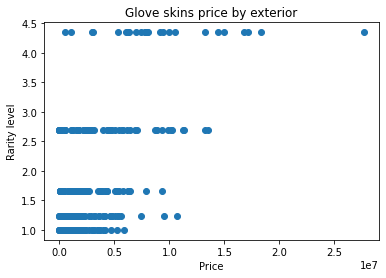

In [69]:
plt.scatter(list(gloves['Min price (VND)']), list(gloves['Exterior as number']))
plt.title('Glove skins price by exterior')
plt.ylabel('Rarity level')
plt.xlabel('Price')
plt.show()

In [82]:
reg = LinearRegression()

## Knife skins:

In [39]:
knife = df[df['Type'] == 'Knife']

In [29]:
# Finding different values in 'Exterior', 'Rarity' and 'Extra' column.
print(knife['Rarity'].unique())
print(knife['Exterior'].unique())
print(knife['Extra'].unique())

['Covert']
['Minimal Wear' 'Factory New' 'Well-Worn' 'Battle-Scarred' 'Field-Tested'
 'None']
['Normal' 'StatTrak™']


In [59]:
print('Avg price by exterior type: ', '\n') 
for item in knife['Exterior'].unique():   
    print(item, ":", knife[knife['Exterior'] == item]['Average price (VND)'].mean())
print(' ')
print('Avg price by extra type: ', '\n') 
for item in knife['Extra'].unique():   
    print(item, ":", knife[knife['Extra'] == item]['Average price (VND)'].mean())
print(' ')

Avg price by exterior type:  

Minimal Wear : 5752951.572475959
Factory New : 8215846.380415192
Well-Worn : 3589223.8626597202
Battle-Scarred : 3466595.3314989004
Field-Tested : 4249078.119844042
None : 6214061.64981579
 
Avg price by extra type:  

Normal : 4762022.881860265
StatTrak™ : 5368626.199471035
 


In [60]:
exterior_dict = {}
exterior_dict['Battle-Scarred'] = 1 # since the average price for battle-scarred knives are lowest, we will enumerate it as 1.
for item in knife['Exterior'].unique(): 
    exterior_dict[item] = round((knife[knife['Exterior'] == item]['Average price (VND)'].mean() / 
    knife[knife['Exterior'] == 'Battle-Scarred']['Average price (VND)'].mean()), 2)
exterior_num = []
for item in list(knife['Exterior']):
    exterior_num.append(exterior_dict[item])
knife['Exterior as number'] = exterior_num

extra_dict = {}
extra_dict['Normal'] = 1 
for item in knife['Extra'].unique(): 
    extra_dict[item] = round((knife[knife['Extra'] == item]['Average price (VND)'].mean() / 
    knife[knife['Extra'] == 'Normal']['Average price (VND)'].mean()), 2)
extra_num = []
for item in list(knife['Extra']):
    extra_num.append(extra_dict[item])
knife['Extra as number'] = extra_num

knife.head()

,Name,Type,Exterior,Rarity,Extra,Average volume sale,Average price (VND),Max price (VND),Days to reach max,Min price (VND),Days to reach min,Price change (%),Time on market (days),Exterior as number,Extra as number
3,★ Karambit | Lore (Minimal Wear),Knife,Minimal Wear,Covert,Normal,1.299663,2.178945e+07,45161864.0,1806,2.104389e+06,1019,2.55,2326,1.66,1.00
7,★ StatTrak™ Huntsman Knife | Autotronic (Facto...,Knife,Factory New,Covert,StatTrak™,1.000000,9.275990e+06,12267543.0,161,6.967859e+06,115,-0.03,290,2.37,1.13
8,★ StatTrak™ Talon Knife | Boreal Forest (Facto...,Knife,Factory New,Covert,StatTrak™,1.000000,1.374043e+07,14418795.0,0,1.306254e+07,1292,-0.08,1374,2.37,1.13
10,★ Karambit | Boreal Forest (Well-Worn),Knife,Well-Worn,Covert,Normal,2.021394,3.759394e+06,19595338.0,3153,5.702951e+03,324,4.98,3379,1.04,1.00
17,★ StatTrak™ Skeleton Knife | Fade (Factory New),Knife,Factory New,Covert,StatTrak™,1.027778,4.133244e+07,48997768.0,946,1.993579e+07,0,1.18,1098,2.37,1.13


In [61]:
print(exterior_dict)
print(extra_dict)

{'Battle-Scarred': 1.0, 'Minimal Wear': 1.66, 'Factory New': 2.37, 'Well-Worn': 1.04, 'Field-Tested': 1.23, 'None': 1.79}
{'Normal': 1.0, 'StatTrak™': 1.13}


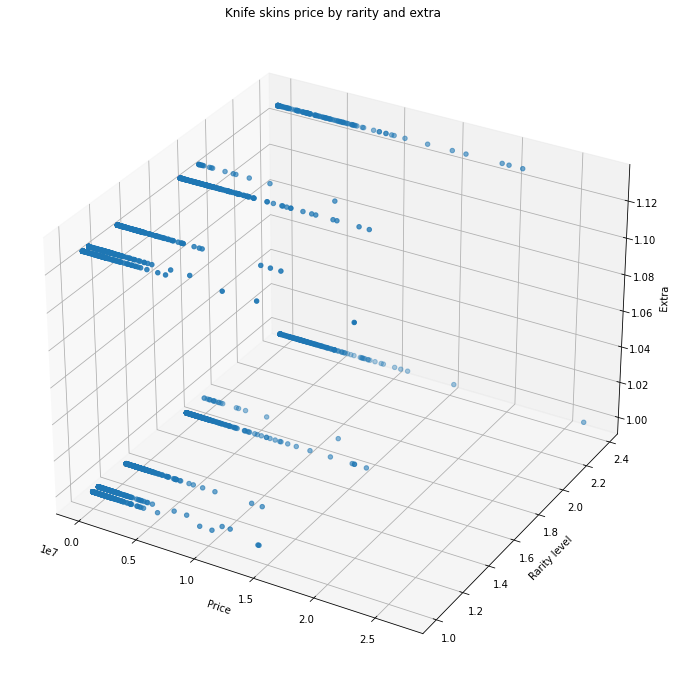

In [62]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(list(knife['Min price (VND)']), list(knife['Exterior as number']), list(knife['Extra as number']))
plt.title('Knife skins price by rarity and extra')
plt.ylabel('Rarity level')
plt.xlabel('Price')
ax.set_zlabel('Extra', rotation=45)
plt.show()

In [43]:
sticker = df[df['Type'] == 'Sticker']

,Name,Type,Exterior,Rarity,Extra,Average volume sale,Average price (VND),Max price (VND),Days to reach max,Min price (VND),Days to reach min,Price change (%),Time on market (days)
0,Sticker | kennyS (Gold) | Boston 2018,Sticker,None,Extraordinary,Normal,2.169355,3.385236e+06,4.254476e+07,1510,629044.125000,269,8.62,1582
9,Sticker | tabseN (Gold) | Krakow 2017,Sticker,None,Extraordinary,Normal,2.672811,1.209372e+06,2.627156e+07,1904,315584.906000,289,51.79,1904
11,Sticker | JW (Gold) | Krakow 2017,Sticker,None,Extraordinary,Normal,2.578261,1.740468e+06,2.231589e+07,1866,282172.094000,0,78.09,1866
12,Sticker | dennis (Gold) | Krakow 2017,Sticker,None,Extraordinary,Normal,2.707627,6.223963e+05,8.028690e+06,1435,138239.266000,17,43.43,1865
13,Sticker | chopper (Gold) | Krakow 2017,Sticker,None,Extraordinary,Normal,2.732794,9.494480e+05,1.340962e+07,1868,95632.977000,17,108.46,1933
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19165,Sticker | electroNic | Stockholm 2021,Sticker,None,High Grade,Normal,4362.341970,1.901362e+02,9.322680e+02,0,89.968000,301,-0.86,385
19166,Sticker | misutaaa | Stockholm 2021,Sticker,None,High Grade,Normal,381.709285,1.888014e+02,1.023776e+03,7,84.401357,356,-0.77,385
19167,Sticker | sjuush | Stockholm 2021,Sticker,None,High Grade,Normal,377.094442,1.913917e+02,5.629130e+02,7,84.948000,249,-0.42,385
19168,Sticker | Boombl4 | Stockholm 2021,Sticker,None,High Grade,Normal,5340.321764,2.041169e+02,7.969520e+02,200,96.593958,379,-0.77,385


In [48]:
# Finding different values in 'Exterior', 'Rarity' and 'Extra' column.
print(sticker['Rarity'].unique())
print(sticker['Exterior'].unique())
print(sticker['Extra'].unique())

['Extraordinary' 'High Grade' 'Remarkable' 'None' 'Exotic']
['None']
['Normal']


In [52]:
print('Avg price by rarity: ', '\n') 
for item in sticker['Rarity'].unique():   
    print(item, ":", sticker[sticker['Rarity'] == item]['Average price (VND)'].mean())
print(' ')
# Rarity: High Grade < Remarkable < Exotic < Extraordinary

Avg price by rarity:  

Extraordinary : 474109.57557939703
High Grade : 34330.1992094321
Remarkable : 82666.36685736824
None : 4803554.757
Exotic : 137344.8635225629
 


In [66]:
rarity_dict = {}
rarity_dict['High Grade'] = 1 # since the average price for high grade sticker are lowest, we will enumerate it as 1.
for item in sticker['Rarity'].unique(): 
    rarity_dict[item] = round((sticker[sticker['Rarity'] == item]['Average price (VND)'].mean() / 
    sticker[sticker['Rarity'] == 'High Grade']['Average price (VND)'].mean()), 2)
rarity_num = []
for item in list(sticker['Rarity']):
    rarity_num.append(exterior_dict[item])
sticker['Rarity as number'] = rarity_num
sticker.head()

,Name,Type,Exterior,Rarity,Extra,Average volume sale,Average price (VND),Max price (VND),Days to reach max,Min price (VND),Days to reach min,Price change (%),Time on market (days),Exterior as number,Rarity as number
0,Sticker | kennyS (Gold) | Boston 2018,Sticker,None,Extraordinary,Normal,2.169355,3.385236e+06,42544756.0,1510,629044.125,269,8.62,1582,13.81,13.81
9,Sticker | tabseN (Gold) | Krakow 2017,Sticker,None,Extraordinary,Normal,2.672811,1.209372e+06,26271558.0,1904,315584.906,289,51.79,1904,13.81,13.81
11,Sticker | JW (Gold) | Krakow 2017,Sticker,None,Extraordinary,Normal,2.578261,1.740468e+06,22315892.0,1866,282172.094,0,78.09,1866,13.81,13.81
12,Sticker | dennis (Gold) | Krakow 2017,Sticker,None,Extraordinary,Normal,2.707627,6.223963e+05,8028690.0,1435,138239.266,17,43.43,1865,13.81,13.81
13,Sticker | chopper (Gold) | Krakow 2017,Sticker,None,Extraordinary,Normal,2.732794,9.494480e+05,13409621.0,1868,95632.977,17,108.46,1933,13.81,13.81


In [67]:
print(rarity_dict)

{'High Grade': 1.0, 'Extraordinary': 13.81, 'Remarkable': 2.41, 'None': 139.92, 'Exotic': 4.0}


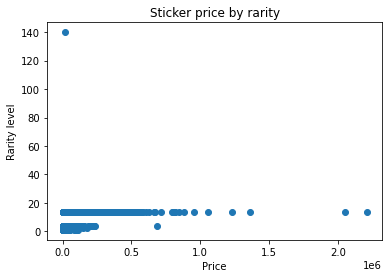

In [68]:
plt.scatter(list(sticker['Min price (VND)']), list(sticker['Rarity as number']))
plt.title('Sticker price by rarity')
plt.ylabel('Rarity level')
plt.xlabel('Price')
plt.show()

## Guns:

In [100]:
df.head()

,Name,Type,Exterior,Rarity,Extra,Average volume sale,Average price (VND),Max price (VND),Days to reach max,Min price (VND),Days to reach min,Price change (%),Time on market (days)
0,Sticker | kennyS (Gold) | Boston 2018,Sticker,None,Extraordinary,Normal,2.169355,3.385236e+06,42544756.0,1510,629044.125,269,8.62,1582
1,Souvenir AWP | Safari Mesh (Well-Worn),Rifle,Well-Worn,Industrial Grade,Souvenir,1.204947,6.137756e+05,7803620.0,2261,14.911,517,7.40,3238
2,Glock-18 | Synth Leaf (Well-Worn),Pistol,Well-Worn,Restricted,Normal,1.940594,6.527500e+05,4243951.0,565,41357.074,0,88.58,1094
3,★ Karambit | Lore (Minimal Wear),Knife,Minimal Wear,Covert,Normal,1.299663,2.178945e+07,45161864.0,1806,2104388.750,1019,2.55,2326
4,★ Specialist Gloves | Emerald Web (Minimal Wear),Gloves,Minimal Wear,Extraordinary,Normal,1.130435,2.193817e+07,46029248.0,2192,7007052.000,453,3.71,2192


In [114]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

guns = filter_rows_by_values(df, "Type", ["Gloves", "Knife", 'Sticker', 'Others', 'Container'])
guns

,Name,Type,Exterior,Rarity,Extra,Average volume sale,Average price (VND),Max price (VND),Days to reach max,Min price (VND),Days to reach min,Price change (%),Time on market (days)
1,Souvenir AWP | Safari Mesh (Well-Worn),Rifle,Well-Worn,Industrial Grade,Souvenir,1.204947,6.137756e+05,7.803620e+06,2261,1.491100e+01,517,7.40,3238
2,Glock-18 | Synth Leaf (Well-Worn),Pistol,Well-Worn,Restricted,Normal,1.940594,6.527500e+05,4.243951e+06,565,4.135707e+04,0,88.58,1094
5,Negev | Mjölnir (Well-Worn),Machinegun,Well-Worn,Classified,Normal,2.063063,7.046626e+06,4.350930e+07,563,5.976138e+05,0,34.23,1082
6,Souvenir M4A1-S | Knight (Minimal Wear),Rifle,Minimal Wear,Classified,Souvenir,1.375000,1.154057e+07,4.463179e+07,2726,4.317884e+06,1070,4.18,2913
20,M4A1-S | Imminent Danger (Factory New),Rifle,Factory New,Covert,Normal,1.000000,4.403238e+07,4.919936e+07,224,3.914220e+07,364,-0.14,364
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18334,Souvenir Sawed-Off | Parched (Field-Tested),Shotgun,Field-Tested,Consumer Grade,Souvenir,372.300260,4.061901e+02,9.699442e+03,49,2.544920e+02,252,-0.59,399
18337,Souvenir MAG-7 | Navy Sheen (Field-Tested),Shotgun,Field-Tested,Consumer Grade,Souvenir,1144.106694,3.506736e+02,3.147878e+03,381,2.352310e+02,251,-0.62,399
18347,Souvenir PP-Bizon | Anolis (Minimal Wear),SMG,Minimal Wear,Consumer Grade,Souvenir,507.898167,4.552443e+02,1.310606e+04,367,2.300170e+02,252,-0.67,399
18401,Souvenir PP-Bizon | Anolis (Field-Tested),SMG,Field-Tested,Consumer Grade,Souvenir,1126.337840,3.450178e+02,3.428015e+03,334,2.240050e+02,252,-0.59,399


In [117]:
print('Avg price by rarity: ', '\n') 
for item in guns['Rarity'].unique():   
    print(item, ":", guns[guns['Rarity'] == item]['Average price (VND)'].mean())
print(' ')

print('Avg price by Exterior: ', '\n') 
for item in guns['Exterior'].unique():   
    print(item, ":", guns[guns['Exterior'] == item]['Average price (VND)'].mean())
print(' ')

print('Avg price by extra: ', '\n') 
for item in guns['Extra'].unique():   
    print(item, ":", guns[guns['Extra'] == item]['Average price (VND)'].mean())
print(' ')

Avg price by rarity:  

Industrial Grade : 86443.93714087906
Restricted : 229928.84888554964
Classified : 916144.8561787975
Covert : 2799996.803098919
Mil-Spec : 74667.4005763578
Consumer Grade : 23959.061648847077
 
Avg price by Exterior:  

Well-Worn : 271807.12950056454
Minimal Wear : 433462.9755574517
Factory New : 766898.1906397495
Battle-Scarred : 310089.6659470856
Field-Tested : 365415.311401361
 
Avg price by extra:  

Souvenir : 638537.1542428073
Normal : 365680.72574670624
StatTrak™ : 482145.2837522548
 


In [120]:
exterior_dict = {}
exterior_dict['Well-Worn'] = 1 
for item in guns['Exterior'].unique(): 
    exterior_dict[item] = round((guns[guns['Exterior'] == item]['Average price (VND)'].mean() / 
    guns[guns['Exterior'] == 'Well-Worn']['Average price (VND)'].mean()), 2)
exterior_num = []
for item in list(guns['Exterior']):
    exterior_num.append(exterior_dict[item])
guns['Exterior as number'] = exterior_num

extra_dict = {}
extra_dict['Normal'] = 1 
for item in guns['Extra'].unique(): 
    extra_dict[item] = round((guns[guns['Extra'] == item]['Average price (VND)'].mean() / 
    guns[guns['Extra'] == 'Normal']['Average price (VND)'].mean()), 2)
extra_num = []
for item in list(guns['Extra']):
    extra_num.append(extra_dict[item])
guns['Extra as number'] = extra_num

rarity_dict = {}
rarity_dict['Consumer Grade'] = 1 
for item in guns['Rarity'].unique(): 
    rarity_dict[item] = round((guns[guns['Rarity'] == item]['Average price (VND)'].mean() / 
    guns[guns['Rarity'] == 'Consumer Grade']['Average price (VND)'].mean()), 2)
rarity_num = []
for item in list(guns['Rarity']):
    rarity_num.append(rarity_dict[item])
guns['Rarity as number'] = rarity_num
guns.head()

,Name,Type,Exterior,Rarity,Extra,Average volume sale,Average price (VND),Max price (VND),Days to reach max,Min price (VND),Days to reach min,Price change (%),Time on market (days),Exterior as number,Extra as number,Rarity as number
1,Souvenir AWP | Safari Mesh (Well-Worn),Rifle,Well-Worn,Industrial Grade,Souvenir,1.204947,6.137756e+05,7803620.0,2261,1.491100e+01,517,7.40,3238,1.00,1.75,3.61
2,Glock-18 | Synth Leaf (Well-Worn),Pistol,Well-Worn,Restricted,Normal,1.940594,6.527500e+05,4243951.0,565,4.135707e+04,0,88.58,1094,1.00,1.00,9.60
5,Negev | Mjölnir (Well-Worn),Machinegun,Well-Worn,Classified,Normal,2.063063,7.046626e+06,43509300.0,563,5.976138e+05,0,34.23,1082,1.00,1.00,38.24
6,Souvenir M4A1-S | Knight (Minimal Wear),Rifle,Minimal Wear,Classified,Souvenir,1.375000,1.154057e+07,44631788.0,2726,4.317884e+06,1070,4.18,2913,1.59,1.75,38.24
20,M4A1-S | Imminent Danger (Factory New),Rifle,Factory New,Covert,Normal,1.000000,4.403238e+07,49199356.0,224,3.914220e+07,364,-0.14,364,2.82,1.00,116.87


In [121]:
print(exterior_dict)
print(rarity_dict)
print(extra_dict)

{'Well-Worn': 1.0, 'Minimal Wear': 1.59, 'Factory New': 2.82, 'Battle-Scarred': 1.14, 'Field-Tested': 1.34}
{'Consumer Grade': 1.0, 'Industrial Grade': 3.61, 'Restricted': 9.6, 'Classified': 38.24, 'Covert': 116.87, 'Mil-Spec': 3.12}
{'Normal': 1.0, 'Souvenir': 1.75, 'StatTrak™': 1.32}
